# <center>Iteracyjne równania liniowe i macierze rzadkie</center>

Instrukcja:
Na zajęciach należy wykonać poniższe zadania, a następnie sporządzić sprawozdanie zawierające odpowiedzi (w postaci kodu) z komentarzami w środowisku Jupyter Notebook i umieścić je na platformie e-learningowej.   

In [2]:
import main
import scipy as sp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pympler import asizeof 
from scipy.sparse import diags
# %load_ext memory_profiler

**Cel zajęć:** Celem zajęć jest zapoznanie się z macierzami rzadkimi, oraz iteracyjnymi metodami rozwiązywania układów równań liniowych w postaci macierzowej. Czyli dana jest macierz [rzadka](https://pl.wikipedia.org/wiki/Macierz_rzadka) $\mathbf{A}$ o wymiarach ($m\times m$) oraz wektor $\mathbf{b}$ ($m\times 1$), należy rozwiązać układ równań postaci:    
$
\mathbf{Ax}=\mathbf{b}
$ 
  
gdzie $\mathbf{A}$ to macierz współczynników z lewej strony równania, wektor $\mathbf{x}$ jest wektorem zmiennych a wektor $\mathbf{b}$ wyników prawej strony równania.  

Do oceny jakości rozwiązania będziemy wykorzystywać residuum (ang. *residual*)
$
\mathbf{r}=\mathbf{b}-\mathbf{Ax}
$ 
  

***Zadanie 1***

W macierzy rzadkiej większość elementów wynosi 0, w związku z tym przechowywanie wprost takiej macierzy w pamięci jest niepraktyczne. Do przechowywania i wykonywania operacji na macierzach rzadkich służy moduł [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html). 
1. Zapoznaj się z różnymi formatami przechowywania macierzy rzadkich.
Na protrzeby ninejszego laboratorium wykorzystany zostanie format [Compressed Sparse Column](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_array.html#scipy.sparse.csc_array)  
2. Przedstaw na jednym wykresie (scatter plot) dla 10 równo rozmieszczonych wartości $m$ z zakresu od $100$ do $10000$ ile pamięci zajmuje ta sama macierz o wymiarach ($m\times m$) w zapisana w formacie $numpy.ndarray$ oraz w formacie $scipy.sparse.csc\_array$ 

Do obliczenia rozmiaru zmiennych monżna wykorzystać funkcję [asizeof.asizeof()](https://pympler.readthedocs.io/en/latest/library/asizeof.html#)

3. Z czego wynika taki wygląd wykresu?


<function matplotlib.pyplot.show(close=None, block=None)>

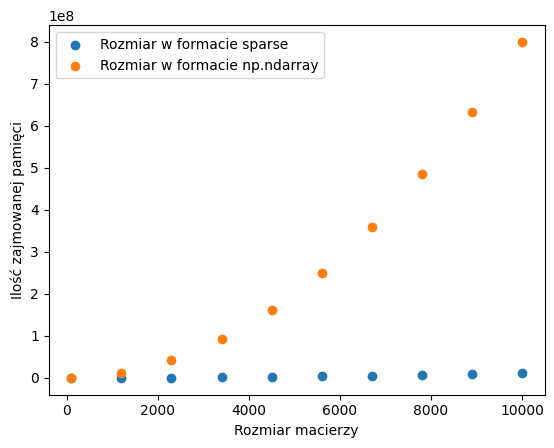

In [3]:
# Generowanie macierzy w formacie scipy.sparse.csc_array
m = np.linspace(100, 10000, 10, dtype = int)
A = []
A_np = []
for i in m:
    x = 0
    sparse = sp.sparse.random(i, i, density=0.01, format='csc')
    A.append(asizeof.asizeof(sparse))
    # Uzyskanie reprezentacji tej samej macierzy w formacie numpy.ndarray
    A_np.append(asizeof.asizeof(sparse.toarray()))
    x += 1
plt.scatter(m, A, label = 'Rozmiar w formacie sparse')
plt.scatter(m, A_np, label = 'Rozmiar w formacie np.ndarray')
plt.xlabel('Rozmiar macierzy')
plt.ylabel('Ilość zajmowanej pamięci')
plt.legend()
plt.show

Formaty sparse pozwalają na efektywne przechowywanie macierzy, które posiadają dużą ilość elementów zerowych. Zamiast przechowywać wszystkie wartości elementów, formaty sparse przechowują jedynie informacje o niezerowych elementach, co pozwala na znaczne ograniczenie zużycia pamięci.

W przypadku formatu CSR (Compressed Sparse Row), dane są przechowywane w postaci trzech tablic: jedna zawiera wartości niezerowe, druga indeksy kolumn tych wartości, a trzecia indeksy wierszy, gdzie te wartości się znajdują. Podobnie w formacie CSC (Compressed Sparse Column), ale w innej konfiguracji.

Z drugiej strony, macierze ndarray przechowują wszystkie swoje wartości, nawet te równe zeru, co przy dużych rozmiarach może znacząco zwiększyć zużycie pamięci.

Dlatego, gdy pracujemy z dużą macierzą która posiada dużą ilość zer, formaty sparse pozwalają na znaczne oszczędzenie pamięci w porównaniu do formatu ndarray. 

***Zadanie 2***

Moduł [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html) implementuje operacje na macierzach rzadkich w dowolnym formacie.  
1. Wygeneruj dwie macierze $\mathbf{A}$  i $\mathbf{B}$ o wymiarach $1000\times 1000$  
2. Porównaj przy pomocy funkcji $\%timeit$ czas potrzebny na wykonanie mnożenia macierzowe $\mathbf{A * B}$  zapisanych w formacie $numpy.ndarray$ oraz $scipy.sparse.csc\_array$ 
3. Z czego wynika różnica?

In [4]:
m = 1000
A_sparse = sp.sparse.random(m, m, density=0.01, format='csc')
A = A_sparse.toarray()
B_sparse = sp.sparse.random(m, m, density=0.01, format='csc')
B = B_sparse.toarray()
print("W formacie ndarray: ")
time1 = %timeit -r 10 -n 100 -o A*B
print("W formacie sparse: ")
time1 = %timeit -r 10 -n 100 -o A_sparse*B_sparse


W formacie ndarray: 
4.3 ms ± 168 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)
W formacie sparse: 
837 µs ± 65.9 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


Wynika to z efektywności operacji mnożenia macierzy w formatach sparse w porównaniu do macierzy gęstych. Tutaj tak jak w poprzednim przykłądzie wynika to z tego, że  formatach sparse jedynie niezerowe elementy są przechowywane, co ogranicza liczbę operacji wymaganych do przeprowadzenia mnożenia macierzy.
Przy użyciu macierzy ndarray, wszystkie elementy są brane pod uwagę podczas operacji mnożenia, nawet jeśli są równe zeru. 

***Zadanie 3***  

Aby metody iteracyjne znalazły rozwiązanie układu należy zadbać o to by macierz $\mathbf{A}$ w układzie $\mathbf{Ax}=\mathbf{b}$ była [diagonalnie zdominowana](https://en.wikipedia.org/wiki/Diagonally_dominant_matrix). Przekształcanie dowolnej macierzy do tej postaci jest skomplikowanym zagadnieniem, w związku z czym na potrzeby tego zadania należy sprawdzić czy wygenerowaliśmy macierz o odpowiedniej własności, aby pominąć krok przekształcania.

1. Uzupełnij funkcję $is\_diagonaly\_dominant()$ w pliku $main.py$ zgodnie z opisem  
(podpowiedź: korzystanie z pętli for nie jest dobrym rozwiązaniem, ponieważ często mamy do czynienia z bardzo dużymi wymiarami, przy których pętle zajmują bardzo duożo czasu. Skoprzystaj z funkcji [np.sum()](https://numpy.org/doc/stable/reference/generated/numpy.sum.html), oraz [np.diagonal()](https://numpy.org/doc/stable/reference/generated/numpy.diagonal.html))  

2. Wygeneruj przy pomocy funkcji $generate\_matrix()$ macierz $\mathbf{A}$ o wymiarach $1000\times 1000$. Przy pomocy funkcji z poprzedniego punktu zweryfikuj, czy wygenerowana macierz jest diagonalnie zdominowana. Wygeneruj również wektor $\mathbf{b}$ $1000\times 1$


    
Istnieje wiele metod iteracyjnego rozwiązywania równań, nie różnią się one znacząco od siebie w kwesti wywołania metody, dlatego w dalszej części zadania należy wybrać jedną z metod: [GMRES](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.gmres.html) lub [Conjugate Gradient](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.cg.html) i dla niej przeprowadzić dalszą analizę. W przypadku wyboru drugiej opcji należy zadbać o to aby macierz była dodatnio określona, poprzez podanie argumentu $is\_simetrical = True$

3. Korzystając z funkcji $residual\_norm()$ z pliku $main.py$ zbadaj wpływ argumentów $tol$ i $maxiter$ na działanie wybranej metody. Sporządź wykresy przedstawiające wartość normy residuum w zależności od zmiany podanych parametrów  
4. Opisz zaobserwowane zależności 


In [5]:
def generate_matrix(m=1000, is_simetrical=False):
    if is_simetrical:
        num_u = np.random.randint(2, m//2)
        num_l = np.random.randint(2, m//2)
        diagonal_values = np.random.rand(num_u)
        matrix = diags(diagonal_values, list(range(0, num_u)), shape=(m, m))
        matrix = matrix + matrix.T
        a = matrix.toarray()
        np.fill_diagonal(a, np.sum(np.abs(a), axis=1) - np.abs(np.diagonal(a)) + np.random.rand(m))
        return sp.sparse.csc_array(a)
    else:
        num_u = np.random.randint(2, m//2)
        num_l = np.random.randint(2, m//2)
        diagonal_values = np.random.rand(num_u + num_l)
        matrix = diags(diagonal_values, list(range(-num_l, num_u)), shape=(m, m))
        a = matrix.toarray()
        np.fill_diagonal(a, np.sum(np.abs(a), axis=1) - np.abs(np.diagonal(a)) + np.random.rand(m))
        return sp.sparse.csc_array(a)

In [6]:
m = 1000
A = generate_matrix(m, True)
b = np.random.rand(m)

isDominated = main.is_diagonaly_dominant(A)
if isDominated == True:
    print('Macierz jest diagonalnie zdominowana')
else: 
    print('Macierz nie jest diagonalnie zdominowana')


Macierz jest diagonalnie zdominowana


C:\Users\Piter\AppData\Local\Temp\ipykernel_17740\2425179393.py:2: RuntimeWarning: invalid value encountered in cast
  max_Iter = max_Iter.astype(int)


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

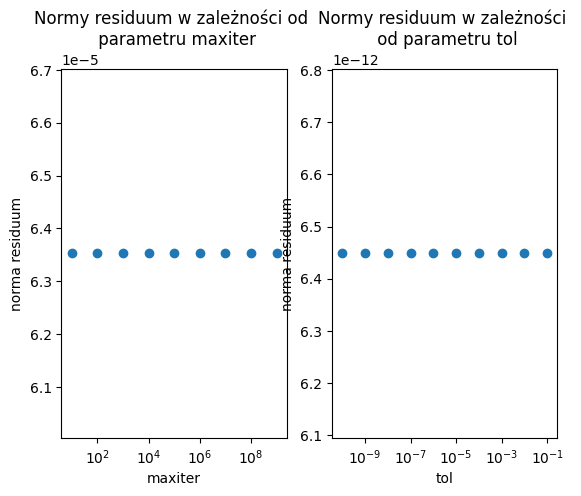

In [8]:
max_Iter = np.logspace(1,10,10)
max_Iter = max_Iter.astype(int)
tols = np.logspace(-1,-10,10)

residualsIters = []
residualsTol = []

for i in max_Iter:
    x, info = sp.sparse.linalg.gmres(A, b, maxiter=1e-12)
    residualsIters.append(main.residual_norm(A,x,b))

for i in tols:
    x, info = sp.sparse.linalg.gmres(A, b, tol=1e-12)
    residualsTol.append(main.residual_norm(A,x,b))
    
plt.subplot(1, 2, 1)
plt.semilogx(max_Iter, residualsIters,'o')
plt.title('Normy residuum w zależności od \n parametru maxiter')
plt.xlabel('maxiter')
plt.ylabel('norma residuum')
plt.subplot(1, 2, 2)

plt.semilogx(tols,residualsTol, 'o')
plt.title('Normy residuum w zależności \n od parametru tol')
plt.xlabel('tol')
plt.ylabel('norma residuum')
plt.tight_layout

Metoda pozwala na szybkie obliczenia przez ograniczoną ilość iteracji, a do tego ma dużą dokładność.
